In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

In [2]:
import torch
from dq
import torchvision
from torchvision import datasets, transforms
import numpy as np
import torch.nn as nn

from itertools import product

In [3]:
device = 'cuda'

In [4]:
fixed_transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

randomed_transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

fixed_trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=fixed_transform_train)
fixed_trainloader = torch.utils.data.DataLoader(fixed_trainset, batch_size=100, shuffle=False, num_workers=2)

trainset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='~/data/cifar10', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
def test(net, loader):
    net.eval()
    correct = 0
    total =  0
    test_loss = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = loss_function(outputs,targets)
            test_loss.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            
    acc = 100.*correct/total
    test_loss_mean = np.mean(test_loss)
    test_loss_std = np.std(test_loss)
    return test_loss_mean, test_loss_std, acc

In [6]:
loss_function = nn.CrossEntropyLoss()

In [47]:
def eval_plot_2d_landscape(net, nettype, loader, basis, r=1.0, scale=11,title='Title'):
    b1,b2 = basis
    x = np.linspace(-r, r, scale)
    y = np.linspace(-r, r,scale)
    nx,ny = len(x), len(y)
    loss_map = np.zeros((nx,ny))
    acc_map = np.zeros((nx,ny))
    std_map = np.zeros((nx,ny))

    tnet = nettype().to(device)
    tnet.load_state_dict(net.state_dict())
    origin = tnet.get_weight_vector()    

    for i,j in product(range(nx),range(ny)):
        vec = origin + b1 * x[i] + b2 * y[j]
        tnet.set_weight_vector(vec)
        loss, std, acc = test(tnet, loader)
        loss_map[i, j] = loss
        acc_map[i, j] = acc
        std_map[i, j] = std
        print('\r',i, j, x[i], y[j], acc, loss,end='')
    print()
    X,Y = np.meshgrid(x,y)

    plt.figure(figsize=(10,10))
    fig, axes = plt.subplots(1,2)

    cs = axes[0].contour(X,Y,loss_map, levels=np.logspace(np.log(loss_map.min()), np.log(loss_map.max()),15,base=np.e))
    plt.clabel(cs, inline=1, fontsize=10)
    axes[0].set_title('Loss')
    cs = axes[1].contour(X,Y,std_map, levels=np.logspace(np.log(std_map.min()), np.log(std_map.max()),15,base=np.e))
    plt.clabel(cs, inline=1, fontsize=10)
    axes[1].set_title('Std')
    fig.suptitle(title)

    return loss_map, acc_map, std_map

In [12]:
def plot_2d_near_checkpoint(checkpoint, nettype, loader, basis= None, r=1.0, scale=11):
    net = torch.nn.DataParallel(nettype())
    checkpoint = torch.load(checkpoint)
    net.load_state_dict(checkpoint['net'])    
    net = net.module

    zero_vector = np.zeros(net.get_weight_vector().shape)
    zero_vector.shape
    if basis is None:
        b1, b2 = np.random.normal(loc = zero_vector, scale=1),np.random.normal(loc = zero_vector, scale=1)
        b1, b2 = net.filterwisely_normalize(b1), net.filterwisely_normalize(b2)
    else:
        b1, b2 = basis
    return eval_plot_2d_landscape(net, nettype, loader, (b1,b2), r=r, scale=scale,title='Title')
    

 20 20 1.0 1.0 9.552 166.369904663085959.23372778320312595472717285137665


<Figure size 720x720 with 0 Axes>

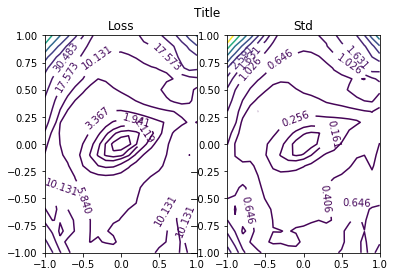

In [49]:
loss_map, acc_map, std_map =  plot_2d_near_checkpoint(checkpoint='./resnet/checkpoint/ResNetNoShort56_optim_sgd_lr_0.01_batch-size_128_seed_1.t7', nettype=ResNetNoShort56, scale=21,loader=fixed_trainloader)

In [ ]:
print('Train loss mean: {:.6f} std: {:.6f} acc:{:.2f}'.format(*test(net_sgd_128, trainloader)))
print('Fixed Train loss mean: {:.6f} std: {:.6f} acc:{:.2f}'.format(*test(net_sgd_128, fixed_trainloader)))
print('Test loss mean: {:.6f} std: {:.6f} acc:{:.2f}'.format(*test(net_sgd_128, testloader)))

# Filterwise Normalization

In [ ]:
b1, b2 = np.random.normal(loc = zero_vector, scale=1),np.random.normal(loc = zero_vector, scale=1)

b1, b2 = net_sgd_128.filterwisely_normalize(b1), net_sgd_128.filterwisely_normalize(b2)

# 2D Visualization

In [ ]:
def plot_2d_landscape(loss_map, std_map,r=1.0, title='Title',):
    scale = loss_map.shape[0]
    x = np.linspace(-r, r, scale)
    y = np.linspace(-r, r,scale)
    X,Y = np.meshgrid(x,y)

    
    fig, axes = plt.subplots(1,2, figsize=(15,10))
    

    cs = axes[0].contour(X,Y,loss_map, levels=np.logspace(np.log(loss_map.min()), np.log(loss_map.max()),15,base=np.e))
    plt.clabel(cs, inline=1, fontsize=10)
    axes[0].set_title('Loss')
    cs = axes[1].contour(X,Y,std_map, levels=np.logspace(np.log(std_map.min()), np.log(std_map.max()),15,base=np.e))
    plt.clabel(cs, inline=1, fontsize=10)
    axes[1].set_title('Std')
    fig.suptitle(title)



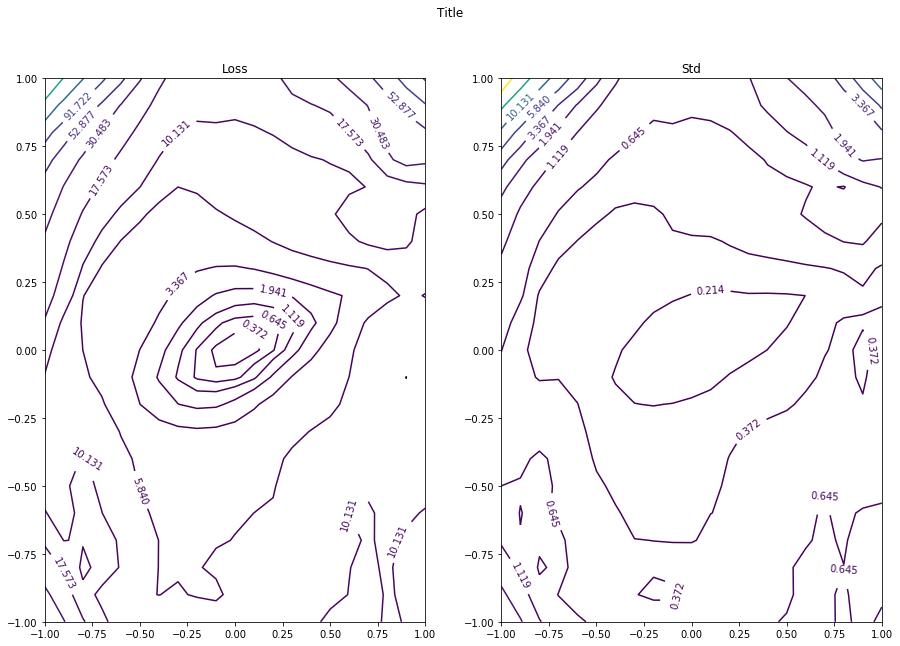

In [50]:
plot_2d_landscape(loss_map,std_map)

In [28]:
import pickle

In [29]:
pickle.dump((loss_map,acc_map,std_map),open('ResNetNoShort110.pkl','wb'))

In [30]:

pickle.dump((loss_map2,acc_map2,std_map2),open('ResNet110.pkl','wb'))

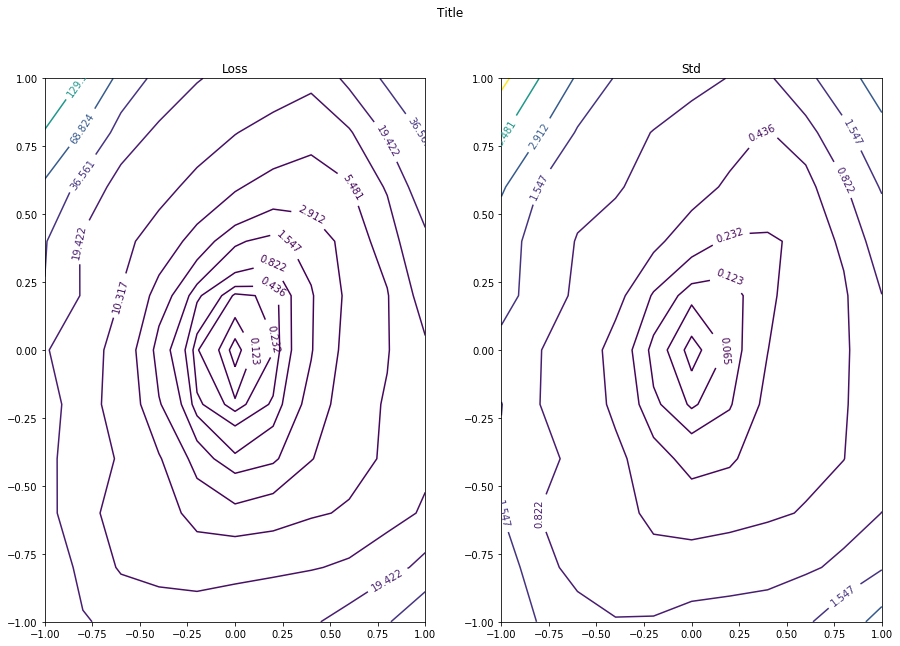

In [36]:

plot_2d_landscape(loss_map, std_map)

In [39]:
loss_map2, _, std_map2 = pickle.load(open('ResNet110.pkl','rb'))

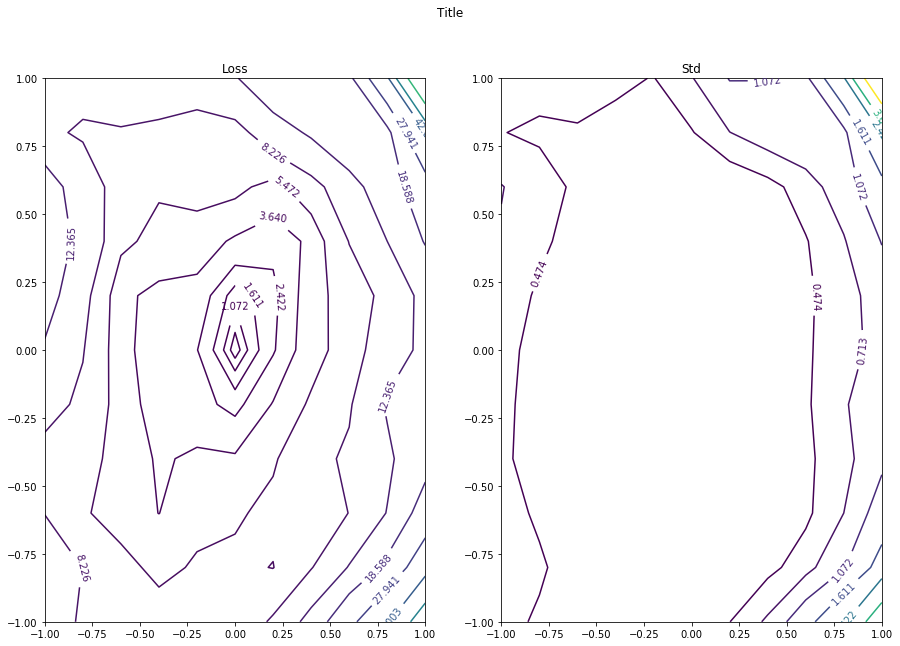

In [40]:

plot_2d_landscape(loss_map2, std_map2)